In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def gaussian_funiction_single(x, mu=0 ,sigma=1):
    '''
    input 
        x : float
    return
        gaussian probility of x which mean is mu, stddev = sigma
    '''
    return math.exp(-1*(x-mu)*(x-mu)/2/sigma/sigma)/sigma/math.sqrt(2*math.pi)
        
def gaussian_funiction(x, mu=0 ,sigma=1):
    '''
    input
        x : list or numpy of float
    return
        gaussian probility of x which mean is mu, stddev = sigma
    
    '''
    if type(x) == list:
        x = np.array(x)
    if type(x).__module__==np.__name__:
        a = np.zeros(len(x))
        for i in range(len(x)):
            a[i] = gaussian_funiction_single(x[i],mu,sigma)
        return a
    else :
        return gaussian_funiction_single(x, mu, sigma)
    
def random_sample(length, Min, Max):
    '''return random seqeunce each value located between Min and Max'''
    return Min+(Max-Min)*np.random.rand(int(length))

def normalizer(x):
    '''
    input : 
        x 1D array
    return :
        1D array normalized for the sum of it to be 1
    '''
    temp = np.zeros(len(x))
    sum = 0
    for i in range(len(x)):
        sum += x[i]
    for i in range(len(x)):
        temp[i]=x[i]/sum
    return temp

def random_choice(states, p):
    '''
    input : 
        states = int
        p = positive 1D array length(=states)
    return :
        select between 0 ~ (states-1) according to probability distribution p
    
    '''
    if states != len(p):
        raise WrongstatesError
    r = np.random.rand()*np.sum(p)
    for i in range(states):
        r-=p[i]
        if r<=0:
            return i

def random_row_generator(x, uniform = False):
    '''
    input :
        x = int
        uniform = boolean default to be false
    
    return :
        unifrom = True
            return x length unifrom 1D array
        uniform = False
            return x length random 1D array 
    
    '''
    if uniform:
         return normalizer(np.ones(x))
    return normalizer(np.random.rand(x))


# Gaussian Mixture Model initial problem setting

In [3]:
def GM_initialization(mean_range, std_range, number, uniform = False):
    means =random_sample(number, -mean_range,mean_range)
    stddevs = random_sample(number,0, std_range)
    weights = random_row_generator(number, uniform)
    return {'weights' : weights, 'means' : means, 'stddevs' : stddevs}

def print_setting(setting):
    '''
    print every variabels in Gaussian mixture model defined by setting
    '''
    print("Weights")
    print(setting['weights'])
    print("Means")
    print(setting['means'])
    print("Stddevs")
    print(setting['stddevs'])

# Observation data generators 

In [5]:
def data_generator(sample_number, GM_setting):   
    '''
    input:
        sample_number : number of samples
        GM_setting : setting represents Gaussian Mixture model
    return : 
        Generate 'sample_number' of datas according to 'GM_setting'
    '''  
    nclusters = len(GM_setting['weights'])
    temp = np.zeros(sample_number)
    for i in range(sample_number):
        cluster = random_choice(nclusters, GM_setting['weights'])
        temp[i] = GM_setting['stddevs'][cluster]*np.random.randn()+GM_setting['means'][cluster]
    return temp

# Learning problem
    x0,x2,..,x(n-1) (sampled data)
    c0,c2,...,c(m-1) (Gaussian Clusters)
    expected[i][j] = P(cj|xi)

In [12]:
def Expectation(observed_datas, GM_setting):
    '''
    input :
        observed_datas = 1D array sequence of observed datas
        GM_setting : setting represents Gaussian Mixture model         
    return :
        expected[i][j](=P(cj|xi))
    '''
    nclusters = len(GM_setting['weights'])
    ndatas = len(observed_datas)
    expected= np.zeros((ndatas, nclusters))
    
    for i in range(ndatas):
        for j in range(nclusters):
            expected[i][j] = GM_setting['weights'][j]*gaussian_funiction_single(observed_datas[i], GM_setting['means'][j], GM_setting['stddevs'][j])
        expected[i] = normalizer(expected[i])
    return expected

In [13]:
print(Expectation(data_generator(5,setting), setting))

[[  8.36203131e-003   6.48282289e-035   9.91637969e-001]
 [  3.49714826e-045   1.00000000e+000   1.94453268e-272]
 [  2.56197102e-051   1.00000000e+000   1.80141061e-306]
 [  2.85722222e-047   1.00000000e+000   6.34526612e-284]
 [  2.37240581e-049   1.00000000e+000   1.80421055e-295]]


In [23]:
def Maximization(observed_datas, expectation):
    '''
    input :
        observed_datas = 1D array sequence of observed datas
        expectation : 2D array(ndatas*nclusters)
    return :
        New parameters which maximizes the probabilit of observed datas based on the expectation
    '''
    ndatas, nclusters = expectation.shape
    
    means = np.zeros(nclusters)
    stddevs = np.zeros(nclusters)
    weights = np.zeros(nclusters)
    
    for j in range(nclusters):
        for i in range(ndatas):
            weights[j] += expectation[i][j]
        weights[j]/=ndatas
    
    for j in range(nclusters):
        temp1 = 0
        temp2 = 0
        for i in range(ndatas):
            temp1+= observed_datas[i]*expectation[i][j]
            temp2+= expectation[i][j]
        means[j] = temp1/temp2
    
    for j in range(nclusters):
        temp1 = 0
        temp2 = 0
        for i in range(ndatas):
            temp1 += (observed_datas[i] - means[j])*(observed_datas[i] - means[j])*expectation[i][j]
            temp2 += expectation[i][j]
        stddevs[j] = math.sqrt(temp1/temp2)
        
    return {'weights' : weights, 'means' : means, 'stddevs' : stddevs}b

In [34]:
def calculate_log_probability(observed_datas, GM_setting):
    '''
    input:
        sample_number : number of samples
        GM_setting : setting represents Gaussian Mixture model
    return : 
        
    '''
    p = 0
    
    nclusters = len(GM_setting['weights'])
    ndatas = len(observed_datas)
    
    for i in range(ndatas):
        temp = 0
        for j in range(nclusters):
            temp+=GM_setting['weights'][j]*gaussian_funiction_single(observed_datas[i], GM_setting['means'][j], GM_setting['stddevs'][j])
        p += math.log(temp)
    
    return p

# Generate observed datas

Weights
[ 0.42585453  0.03463495  0.53951052]
Means
[-0.90326953 -4.26577148  4.01803455]
Stddevs
[ 0.4189955   0.04781419  0.6046283 ]
Weights
[ 0.0332      0.53990004  0.42689996]
Means
[-4.26672244  4.00876775 -0.9080126 ]
Stddevs
[ 0.04766073  0.602322    0.41751771]


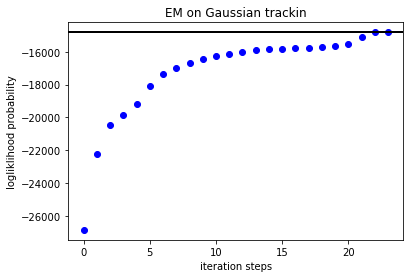

In [43]:
# Fixed
number = 3

# Answer setting
mean_range = 5
stddev_range = 1 
number = 3
answer_setting = GM_initialization(mean_range, stddev_range, number)
print_setting(answer_setting)

# Data generate
nsamples = 10000
observed = data_generator(nsamples, answer_setting)
challenge_probability = calculate_log_probability(observed, answer_setting)

#print(observed)

# User setting
mean_range = 10
stddev_range = 5 

learning_setting = GM_initialization(mean_range, stddev_range, number)
iteration = 40

probability = []
probability.append(calculate_log_probability(observed,learning_setting))
for iter in range(iteration):
    learning_setting = Maximization(observed, Expectation(observed, learning_setting))
    probability.append(calculate_log_probability(observed,learning_setting))
    if abs(probability[iter]-probability[iter+1])<1:
        break;
probability = np.array(probability)
print_setting(learning_setting)
plt.plot(probability,'bo')
plt.axhline(y=challenge_probability, xmin=0, xmax=len(probability) - 1, linewidth=2, color = 'k')
plt.title("EM on Gaussian trackin")
plt.ylabel("logliklihood probability")
plt.xlabel("iteration steps")
plt.show()